# Preparação Dos Dados


In [6]:
import pandas as pd
import numpy as np
import os

# Leitura dos dados originais
# Mostrar todas as colunas
pd.set_option('display.max_columns', None)
file_path = 'data/TUCURUI_DIARIA_1939_2016.xlsx'
data = pd.read_excel(file_path, header=None, names=['Vazao'])

# Função para calcular derivadas percentuais


def calcular_derivadas(data):
    data['V1'] = data['Vazao'].pct_change() * 100  # Primeira derivada
    data['V2'] = data['V1'].diff()  # Segunda derivada
    return data

# Função para criar defasagens


def criar_defasagens(data, colunas, entradas):
    defasagens_list = []

    for col in colunas:
        for i in range(entradas, 0, -1):
            defasagens_list.append(data[col].shift(
                i).rename(f'Entrada_{col}_{i}'))
        defasagens_list.append(data[col])

    for i in range(1, 12):
        defasagens_list.append(data['Vazao'].shift(-i).rename(f'Saida_{i}'))
    defasagens = pd.concat(defasagens_list, axis=1)
    return defasagens


# Função para criar colunas binárias
def criar_colunas_binarias(data):
    # Inicializar as colunas binárias com zeros
    data['Bin1'] = 0
    data['Bin2'] = 0
    data['Bin3'] = 0

    # Aplicar as condições para definir os valores das colunas binárias
    data.loc[(data['V1'] > 40) & (data['V2'] > 0),
             ['Bin1', 'Bin2', 'Bin3']] = [1, 0, 0]
    data.loc[(data['V1'] < -40) & (data['V2'] < 0),
             ['Bin1', 'Bin2', 'Bin3']] = [0, 0, 1]
    data.loc[~((data['V1'] > 40) & (data['V2'] > 0)) & ~(
        (data['V1'] < -40) & (data['V2'] < 0)), ['Bin1', 'Bin2', 'Bin3']] = [0, 1, 0]

    return data

# **MODELO 1**

In [4]:
# Criar datasets com defasagem apenas na coluna 'Vazao'
data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)

# Pasta onde os arquivos serão salvos

output_folder = 'data/modelo_1'

# Criar a pasta se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos para os arquivos Excel
file_path_15 = os.path.join(output_folder, 'data_15_dias.xlsx')
file_path_30 = os.path.join(output_folder, 'data_30_dias.xlsx')
file_path_45 = os.path.join(output_folder, 'data_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_15.to_excel(file_path_15, index=False)
data_30.to_excel(file_path_30, index=False)
data_45.to_excel(file_path_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


# **MODELO 2**



In [5]:
# Calcular derivadas
data_com_derivadas = calcular_derivadas(data)

# Criar datasets com defasagem nas colunas 'V2', 'V1' e 'Vazao'
data_derivadas_15 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 15)
data_derivadas_30 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 30)
data_derivadas_45 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 45)

# Pasta onde os arquivos serão salvos, dentro de 'data'
output_folder = 'data/modelo_2'

# Criar a pasta 'modelo_2' dentro de 'data' se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos  para os arquivos Excel
file_path_derivadas_15 = os.path.join(output_folder, 'data_derivadas_15_dias.xlsx')
file_path_derivadas_30 = os.path.join(output_folder, 'data_derivadas_30_dias.xlsx')
file_path_derivadas_45 = os.path.join(output_folder, 'data_derivadas_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_derivadas_15.to_excel(file_path_derivadas_15, index=False)
data_derivadas_30.to_excel(file_path_derivadas_30, index=False)
data_derivadas_45.to_excel(file_path_derivadas_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


In [6]:
data = data[['V2', 'V1', 'Vazao']]
data

,V2,V1,Vazao
0,NaN,NaN,2110
1,NaN,-0.995261,2089
2,-0.871661,-1.866922,2050
3,-0.084298,-1.951220,2010
4,1.005946,-0.945274,1991
...,...,...,...
17284,-1.364289,0.389105,5418
17285,-3.028455,-2.639350,5275
17286,-1.531266,-4.170616,5055
17287,-0.517811,-4.688427,4818


# **MODELO 3**


In [11]:
# Adicionar colunas binárias ao DataFrame
data_com_derivadas = calcular_derivadas(data)
data_com_binarias = criar_colunas_binarias(data_com_derivadas).dropna()

data_com_binarias[['Bin1', 'Bin2', 'Bin3', 'V2', 'V1', 'Vazao']].head(10)

,Bin1,Bin2,Bin3,V2,V1,Vazao
2,0,1,0,-0.871661,-1.866922,2050
3,0,1,0,-0.084298,-1.951220,2010
4,0,1,0,1.005946,-0.945274,1991
5,0,1,0,-0.059247,-1.004520,1971
6,0,1,0,1.004520,0.000000,1971
7,0,1,0,0.000000,0.000000,1971
8,0,1,0,0.507357,0.507357,1981
9,0,1,0,-0.507357,0.000000,1981
10,0,1,0,0.959112,0.959112,2000
11,0,1,0,-0.959112,0.000000,2000


In [4]:
# Criar datasets com defasagem nas colunas binárias e 'Vazao'
data_binarias_15 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 15)
data_binarias_30 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 30)
data_binarias_45 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 45)

# Pasta onde os arquivos serão salvos, dentro de 'data'
output_folder = 'data/modelo_3'

# Criar a pasta 'modelo_3' dentro de 'data' se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos para os arquivos Excel
file_path_binarias_15 = os.path.join(output_folder, 'data_binarias_15_dias.xlsx')
file_path_binarias_30 = os.path.join(output_folder, 'data_binarias_30_dias.xlsx')
file_path_binarias_45 = os.path.join(output_folder, 'data_binarias_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_binarias_15.to_excel(file_path_binarias_15, index=False)
data_binarias_30.to_excel(file_path_binarias_30, index=False)
data_binarias_45.to_excel(file_path_binarias_45, index=False)

print("DataFrames salvos com sucesso!")


DataFrames salvos com sucesso!


In [10]:

file_path = 'data/modelo_3/data_binarias_15_dias.xlsx'
data3 = pd.read_excel(file_path,usecols=['Bin1','Bin2','Bin3','Vazao'])
data3

,Bin1,Bin2,Bin3,Vazao
0,0,1,0,2050
1,0,1,0,2010
2,0,1,0,1991
3,0,1,0,1971
4,0,1,0,1971
...,...,...,...,...
17282,0,1,0,5418
17283,0,1,0,5275
17284,0,1,0,5055
17285,0,1,0,4818


# **TREINAMENTO**


In [5]:
import tensorflow as tf



# Função para preparar os dados (remover NaNs e separar em treino e teste)
def prepare_data(data, features, target, test_size=0.2):
    data = data.dropna()
    X = data[features]
    y = data[target]
    split_idx = int(len(data) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

# **TREINAMENTO - MODELO 1**


In [12]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras.optimizers import Adam

data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)
# Função para preparar dados para treinamento e teste
def preparar_dados(data):
    data = data.dropna()
    X = data.iloc[:, :-12].values
    y = data.iloc[:, -12:].values
    return X, y

X_15, y_15 = preparar_dados(data_15)
X_30, y_30 = preparar_dados(data_30)
X_45, y_45 = preparar_dados(data_45)



In [13]:
# Mostrar as primeiras 5 linhas de X e Y 
print("X_15 (Entradas):")
print(pd.DataFrame(X_15).head())

print("\nY_15 (Saídas):")
print(pd.DataFrame(y_15).head())

X_15 (Entradas):
       0       1       2       3       4       5       6       7       8   \
0  2110.0  2089.0  2050.0  2010.0  1991.0  1971.0  1971.0  1971.0  1981.0   
1  2089.0  2050.0  2010.0  1991.0  1971.0  1971.0  1971.0  1981.0  1981.0   
2  2050.0  2010.0  1991.0  1971.0  1971.0  1971.0  1981.0  1981.0  2000.0   
3  2010.0  1991.0  1971.0  1971.0  1971.0  1981.0  1981.0  2000.0  2000.0   
4  1991.0  1971.0  1971.0  1971.0  1981.0  1981.0  2000.0  2000.0  2000.0   

       9       10      11      12      13      14  
0  1981.0  2000.0  2000.0  2000.0  1981.0  1990.0  
1  2000.0  2000.0  2000.0  1981.0  1990.0  1991.0  
2  2000.0  2000.0  1981.0  1990.0  1991.0  1971.0  
3  2000.0  1981.0  1990.0  1991.0  1971.0  1942.0  
4  1981.0  1990.0  1991.0  1971.0  1942.0  1913.0  

Y_15 (Saídas):
       0       1       2       3       4       5       6       7       8   \
0  1991.0  1971.0  1942.0  1913.0  1875.0  1857.0  1829.0  1847.0  1875.0   
1  1971.0  1942.0  1913.0  1875.0  185

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step

Dataset com 15 defasagens: Erro Médio = 3544669.9090762003

Dataset com 30 defasagens: Erro Médio = 3773458.1662402996

Dataset com 45 defasagens: Erro Médio = 3484939.3303219965


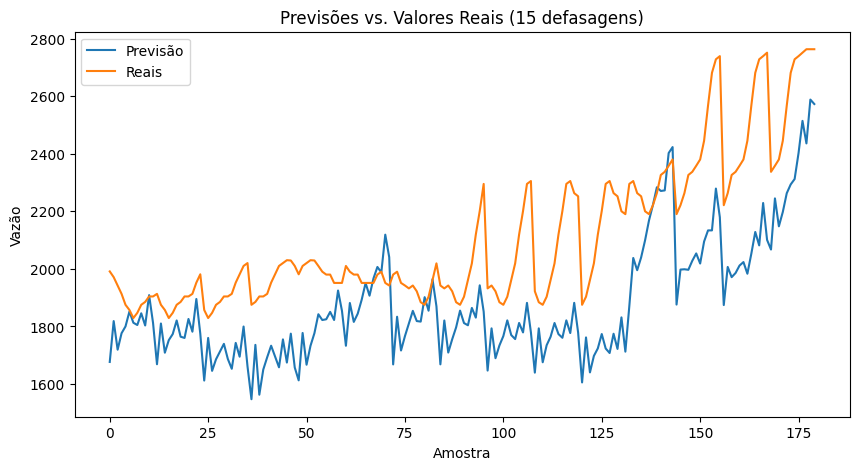

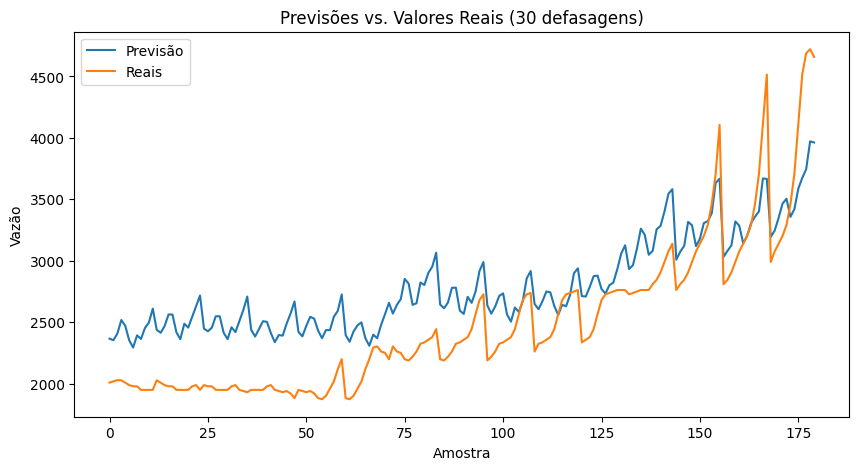

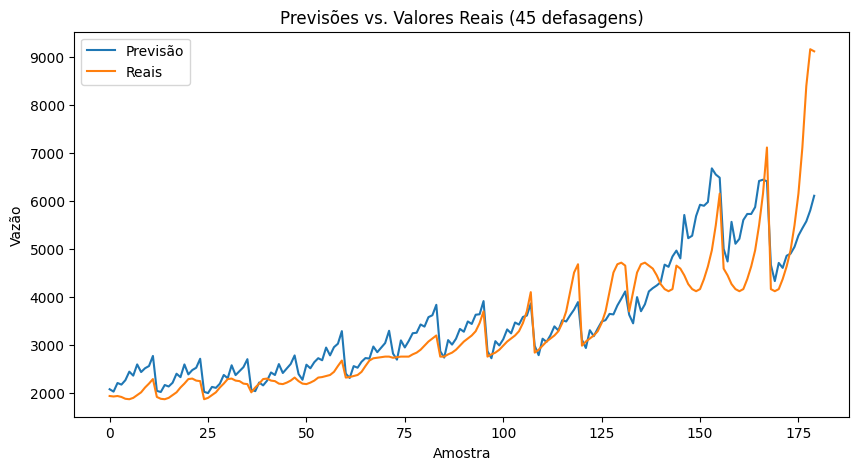

DataFrame com as primeiras 15 previsões e valores reais (15 defasagens):
       Previsão   Reais
0   1676.489502  1991.0
1   1818.439453  1971.0
2   1719.008667  1942.0
3   1776.208618  1913.0
4   1799.884888  1875.0
5   1851.627808  1857.0
6   1812.661621  1829.0
7   1804.763672  1847.0
8   1845.502441  1875.0
9   1803.158447  1885.0
10  1908.572388  1904.0
11  1811.835693  1904.0
12  1668.471924  1913.0
13  1810.028320  1875.0
14  1708.549683  1857.0

DataFrame com as primeiras 15 previsões e valores reais (30 defasagens):
       Previsão   Reais
0   2367.431885  2010.0
1   2354.870117  2020.0
2   2408.962402  2030.0
3   2519.084717  2029.0
4   2472.238525  2010.0
5   2354.392334  1990.0
6   2295.872803  1980.0
7   2394.176270  1980.0
8   2365.044922  1951.0
9   2453.810791  1951.0
10  2498.534912  1951.0
11  2611.891846  1951.0
12  2438.507080  2029.0
13  2415.493164  2010.0
14  2469.950684  1990.0

DataFrame com as primeiras 15 previsões e valores reais (45 defasagens):
       Prev

In [14]:
import matplotlib.pyplot as plt
# Função para construir o modelo MLP



def criar_modelo(input_dim, output_dim):

    model = Sequential()

    model.add(InputLayer(shape=(input_dim,)))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(output_dim, activation='linear'))

    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model


# Função para realizar a validação cruzada e retornar previsões



def validacao_cruzada(X, y, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    erros = []

    previsoes = []

    valores_reais = []


    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]

        y_train, y_test = y[train_index], y[test_index]


        scaler_X = StandardScaler()

        scaler_y = StandardScaler()


        X_train_scaled = scaler_X.fit_transform(X_train)

        X_test_scaled = scaler_X.transform(X_test)


        y_train_scaled = scaler_y.fit_transform(y_train)

        y_test_scaled = scaler_y.transform(y_test)


        modelo = criar_modelo(X_train_scaled.shape[1], y_train_scaled.shape[1])

        modelo.fit(X_train_scaled, y_train_scaled,
                   epochs=10, batch_size=32, verbose=0)


        predicoes = modelo.predict(X_test_scaled)

        predicoes_inversas = scaler_y.inverse_transform(predicoes)


        erro = mean_squared_error(y_test, predicoes_inversas)

        erros.append(erro)


        # Salvar as previsões e valores reais para um dos splits

        previsoes.extend(predicoes_inversas)
        valores_reais.extend(y_test)


    return np.mean(erros), previsoes, valores_reais


# Função para criar DataFrame e plotar gráfico
def criar_dataframe_e_plotar(previsoes, valores_reais, n=15, title='Previsões vs. Valores Reais'):
    df_comparacao = pd.DataFrame({
        'Previsão': np.array(previsoes[:n]).flatten(),
        'Reais': np.array(valores_reais[:n]).flatten()
    })
    
    # Plotar as previsões e valores reais
    plt.figure(figsize=(10, 5))
    plt.plot(df_comparacao['Previsão'], label='Previsão')
    plt.plot(df_comparacao['Reais'], label='Reais')
    plt.title(title)
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()
    
    return df_comparacao

# Realizar a validação cruzada para cada dataset

media_erro_15, previsoes_15, valores_reais_15 = validacao_cruzada(X_15, y_15)

media_erro_30, previsoes_30, valores_reais_30 = validacao_cruzada(X_30, y_30)

media_erro_45, previsoes_45, valores_reais_45 = validacao_cruzada(X_45, y_45)


print(f'\nDataset com 15 defasagens: Erro Médio = {media_erro_15}')

print(f'\nDataset com 30 defasagens: Erro Médio = {media_erro_30}')

print(f'\nDataset com 45 defasagens: Erro Médio = {media_erro_45}')

df_15 = criar_dataframe_e_plotar(previsoes_15, valores_reais_15, title='Previsões vs. Valores Reais (15 defasagens)')
df_30 = criar_dataframe_e_plotar(previsoes_30, valores_reais_30, title='Previsões vs. Valores Reais (30 defasagens)')
df_45 = criar_dataframe_e_plotar(previsoes_45, valores_reais_45, title='Previsões vs. Valores Reais (45 defasagens)')

# Exibir os DataFrames
print("DataFrame com as primeiras 15 previsões e valores reais (15 defasagens):")
print(df_15.head(15))

print("\nDataFrame com as primeiras 15 previsões e valores reais (30 defasagens):")
print(df_30.head(15))

print("\nDataFrame com as primeiras 15 previsões e valores reais (45 defasagens):")
print(df_45.head(15))




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# Função para construir o modelo MLP
def criar_modelo(input_dim, output_dim):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


# Função para criar DataFrame e plotar gráfico
def criar_dataframe_e_plotar(previsoes, valores_reais, n=15, title='Previsões vs. Valores Reais'):
    df_comparacao = pd.DataFrame({
        'Previsão': np.array(previsoes[:n]).flatten(),
        'Reais': np.array(valores_reais[:n]).flatten()
    })
    
    # Plotar as previsões e valores reais
    plt.figure(figsize=(10, 5))
    plt.plot(df_comparacao['Previsão'], label='Previsão', marker='o')
    plt.plot(df_comparacao['Reais'], label='Reais', marker='x')
    plt.title(title)
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()
    
    return df_comparacao

# Separar os dados em treino, validação e teste
def separar_dados(X, y, test_size=0.4, val_size=0.5):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_15_train, X_15_val, X_15_test, y_15_train, y_15_val, y_15_test = separar_dados(X_15, y_15)
X_30_train, X_30_val, X_30_test, y_30_train, y_30_val, y_30_test = separar_dados(X_30, y_30)
X_45_train, X_45_val, X_45_test, y_45_train, y_45_val, y_45_test = separar_dados(X_45, y_45)

# Normalização dos dados
def normalizar_dados(X_train, X_val, X_test, y_train, y_val, y_test):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_y

X_15_train_scaled, X_15_val_scaled, X_15_test_scaled, y_15_train_scaled, y_15_val_scaled, y_15_test_scaled, scaler_y_15 = normalizar_dados(X_15_train, X_15_val, X_15_test, y_15_train, y_15_val, y_15_test)
X_30_train_scaled, X_30_val_scaled, X_30_test_scaled, y_30_train_scaled, y_30_val_scaled, y_30_test_scaled, scaler_y_30 = normalizar_dados(X_30_train, X_30_val, X_30_test, y_30_train, y_30_val, y_30_test)
X_45_train_scaled, X_45_val_scaled, X_45_test_scaled, y_45_train_scaled, y_45_val_scaled, y_45_test_scaled, scaler_y_45 = normalizar_dados(X_45_train, X_45_val, X_45_test, y_45_train, y_45_val, y_45_test)

# Validação cruzada manual
def validacao_cruzada(X_train_scaled, y_train_scaled, criar_modelo, input_dim, output_dim, n_splits=5, epochs=100, batch_size=32):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]
        
        model = criar_modelo(input_dim, output_dim)
        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
        
        y_val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores), np.std(mse_scores)

# Treinar e avaliar os modelos usando validação cruzada manual
mse_15_mean, mse_15_std = validacao_cruzada(X_15_train_scaled, y_15_train_scaled, criar_modelo, X_15_train_scaled.shape[1], y_15_train_scaled.shape[1])
mse_30_mean, mse_30_std = validacao_cruzada(X_30_train_scaled, y_30_train_scaled, criar_modelo, X_30_train_scaled.shape[1], y_30_train_scaled.shape[1])
mse_45_mean, mse_45_std = validacao_cruzada(X_45_train_scaled, y_45_train_scaled, criar_modelo, X_45_train_scaled.shape[1], y_45_train_scaled.shape[1])

print(f'Dataset com 15 defasagens - Erro na Validação (Média): {mse_15_mean} - Desvio Padrão: {mse_15_std}')
print(f'Dataset com 30 defasagens - Erro na Validação (Média): {mse_30_mean} - Desvio Padrão: {mse_30_std}')
print(f'Dataset com 45 defasagens - Erro na Validação (Média): {mse_45_mean} - Desvio Padrão: {mse_45_std}')

# Treinar os modelos finais e avaliar no conjunto de teste
modelo_15 = criar_modelo(X_15_train_scaled.shape[1], y_15_train_scaled.shape[1])
modelo_15.fit(X_15_train_scaled, y_15_train_scaled, epochs=100, batch_size=32, verbose=0)
previsoes_15_test = modelo_15.predict(X_15_test_scaled)
previsoes_15_test_inv = scaler_y_15.inverse_transform(previsoes_15_test)

modelo_30 = criar_modelo(X_30_train_scaled.shape[1], y_30_train_scaled.shape[1])
modelo_30.fit(X_30_train_scaled, y_30_train_scaled, epochs=100, batch_size=32, verbose=0)
previsoes_30_test = modelo_30.predict(X_30_test_scaled)
previsoes_30_test_inv = scaler_y_30.inverse_transform(previsoes_30_test)

modelo_45 = criar_modelo(X_45_train_scaled.shape[1], y_45_train_scaled.shape[1])
modelo_45.fit(X_45_train_scaled, y_45_train_scaled, epochs=100, batch_size=32, verbose=0)
previsoes_45_test = modelo_45.predict(X_45_test_scaled)
previsoes_45_test_inv = scaler_y_45.inverse_transform(previsoes_45_test)

print(f'Dataset com 15 defasagens - Erro no Teste: {mean_squared_error(scaler_y_15.inverse_transform(y_15_test_scaled), previsoes_15_test_inv)}')
print(f'Dataset com 30 defasagens - Erro no Teste: {mean_squared_error(scaler_y_30.inverse_transform(y_30_test_scaled), previsoes_30_test_inv)}')
print(f'Dataset com 45 defasagens - Erro no Teste: {mean_squared_error(scaler_y_45.inverse_transform(y_45_test_scaled), previsoes_45_test_inv)}')

# Plotar previsões comparadas com os valores reais
plotar_previsoes(previsoes_15_test_inv[:, 0], scaler_y_15.inverse_transform(y_15_test_scaled)[:, 0], 'Previsões vs Valores Reais (15 defasagens)')
plotar_previsoes(previsoes_30_test_inv[:, 0], scaler_y_30.inverse_transform(y_30_test_scaled)[:, 0], 'Previsões vs Valores Reais (30 defasagens)')
plotar_previsoes(previsoes_45_test_inv[:, 0], scaler_y_45.inverse_transform(y_45_test_scaled)[:, 0], 'Previsões vs Valores Reais (45 defasagens)')

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir dados em treino e teste
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=0.3, random_state=42)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.3, random_state=42)
X_train_45, X_test_45, y_train_45, y_test_45 = train_test_split(X_45, y_45, test_size=0.3, random_state=42)
# Dividir dados de treino em treino e validação
X_train_15, X_val_15, y_train_15, y_val_15 = train_test_split(X_train_15, y_train_15, test_size=0.2, random_state=42)
X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.2, random_state=42)
X_train_45, X_val_45, y_train_45, y_val_45 = train_test_split(X_train_45, y_train_45, test_size=0.2, random_state=42)


# **TREINAMENTO - MODELO 2**


In [30]:
features = data_derivadas_15.filter(regex='^(?!.*Saida).*$').columns.tolist()
target = data_derivadas_15.filter(regex='^Saida').columns.tolist()

X_train, X_test, y_train, y_test = prepare_data(data_derivadas_15, features, target)

# Definição da arquitetura do modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),  # Camada oculta com ativação ReLU
    Dense(32, activation='relu'),  # Segunda camada oculta com ativação ReLU
    Dense(len(target))  # Camada de saída
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 41111004.0000 - val_loss: 3790533.2500
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6385743.5000 - val_loss: 3386345.2500
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5350353.0000 - val_loss: 3074222.2500
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4866292.0000 - val_loss: 2966272.0000
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4738063.5000 - val_loss: 2787919.2500
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4575716.5000 - val_loss: 2882900.7500
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4288050.0000 - val_loss: 2696092.7500
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4353732.5000 - val_loss: 2647393.5000
Epoch 9/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4157890.2500 - val_loss: 2984696.2500
Epoch 10/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4228058.0000 - val_loss: 4006668.2500
Epoch 11/50
432/432 ━━━━━━━━━

# **Avaliação do modelo**


**MAPE (ERRO PERCENTUAL MÉDIO)**

In [35]:
# Avaliação do modelo com Erro Médio Absoluto Percentual (MAPE)
predictions = model.predict(X_test)
mape = tf.keras.losses.MeanAbsolutePercentageError()
mape_value = mape(y_test, predictions).numpy()
print(f'Erro Percentual Médio no conjunto de teste: {mape_value}%')

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
Erro Percentual Médio no conjunto de teste: 12.433731079101562%


**PREVISÃO x REAL**

In [34]:
import pandas as pd

# Criar um DataFrame com as primeiras 15 previsões e valores reais
df_comparacao = pd.DataFrame({
    'Previsão': predictions[:15].flatten(),
    'Reais': y_test.values[:15].flatten()
})

# Exibir a tabela
print(df_comparacao)

        Previsão   Reais
0    2772.447021  2972.0
1    2627.369385  2896.0
2    2490.411133  2885.0
3    2377.333008  2741.0
4    2279.763184  2800.0
..           ...     ...
160  2143.237061  2517.0
161  2105.345947  2476.0
162  2020.250977  2437.0
163  2006.711792  2364.0
164  1988.831665  2363.0

[165 rows x 2 columns]


**GRÁFICO**


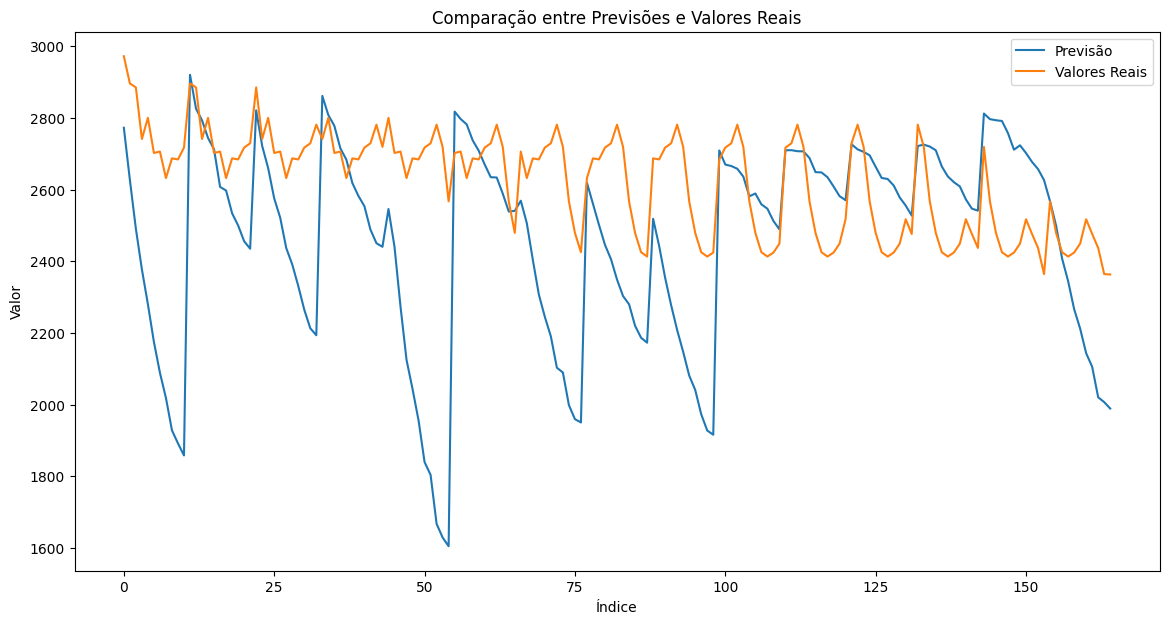

In [33]:
import matplotlib.pyplot as plt

# Plotar previsões e valores reais
plt.figure(figsize=(14, 7))
plt.plot(df_comparacao['Previsão'], label='Previsão')
plt.plot(df_comparacao['Reais'], label='Valores Reais')
plt.legend()
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()